In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error,mean_absolute_percentage_error,make_scorer
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load data
data = pd.read_excel("../input_data/dataset.xlsx")
sel_col = ['Vf','AR', 'RI', "fc", 'sigcc', 'bar',
       "hzerominusa", 'hj', 'car', 'jar', 'bj',
       'n', 'A0', 's', 'fy', 'rogross']
data = data.sample(frac=1, random_state=33).reset_index(drop=True)
y = data[['vj']]
X = data[sel_col]
print(X.columns)
np.random.seed(42)

Index(['Vf', 'AR', 'RI', 'fc', 'sigcc', 'bar', 'hzerominusa', 'hj', 'car',
       'jar', 'bj', 'n', 'A0', 's', 'fy', 'rogross'],
      dtype='object')


In [3]:
# Helper function to try out different kernels and find the best epsilon and regularization combination using training data
def nested_parameter_testing(kern, training_in, training_out, validation_in, validation_out):
    epsilon_values = np.round(np.arange(0, 4, 0.1), decimals=1)
    
    reg_values = np.arange(1, 10, 1)
    mse_results = []
    training_out = training_out.to_numpy().flatten()
    # Nested loop for epsilon and regularization
    for reg in reg_values:
        for ep in epsilon_values:
            svr = SVR(C=reg, epsilon=ep, kernel=kern)
            svr.fit(training_in, training_out)
            predictions = svr.predict(validation_in)

            mse = mean_squared_error(validation_out, predictions)
            mse_results.append((reg, ep, mse))


    best_reg, best_epsilon, best_mse = min(mse_results, key=lambda x: x[2])

    print(f"The best combination is Regularization = {best_reg}, Epsilon = {best_epsilon} with the lowest MSE of {best_mse}")

    # Visualization
    mse_matrix = np.array(mse_results).reshape(len(reg_values), len(epsilon_values), 3)
    mse_values = mse_matrix[:, :, 2]
    plt.figure(figsize=(8, 8))
    for idx, reg in enumerate(reg_values):
        line_width = 5 if reg == best_reg else 1  # Make the best line bold
        plt.plot(epsilon_values, mse_values[idx, :], label=f'C={reg}', lw=line_width)

    # Highlight the lowest MSE
    plt.scatter([best_epsilon], [best_mse], color='red', label='Lowest MSE', zorder=5)

    plt.xlabel('Epsilon')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title(f'MSE for Different Regularization and Epsilon Values ({kern} kernel)')
    plt.legend(title="Regularization")
    plt.grid(True)
    plt.savefig(f'../svr_results/svr_performance_metrics_{kern}_kernel.png', dpi =1000)
    plt.show()
    

    return best_reg, best_epsilon




## Case 1 - Using provided formula

The best combination is Regularization = 3, Epsilon = 1.3 with the lowest MSE of 1.4572783095416746


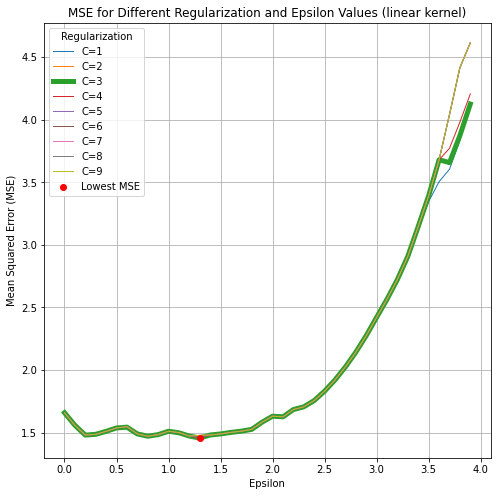

In [4]:
data['term_1_n_fc'] = data["γ"] * (1 + 0.3 * data['n']) * data['sigcc']
data['term_RI_fc'] = data['RI'] * data['sigcc'] / data['jar']
data['term_fy_A0'] = data["γ"] * data['fy'] * data['rogross']
X_case1 = data[['term_1_n_fc', 'term_RI_fc', 'term_fy_A0']]
y_case1 = data['vj']

X_train_case1, X_temp, y_train_case1, y_temp = train_test_split(X_case1, y_case1, test_size=0.4, random_state=42)
X_val_case1, X_test_case1, y_val_case1, y_test_case1 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Find the best combination for CASE 1
best_reg_linear, best_epsilon_linear = nested_parameter_testing("linear",X_train_case1,y_train_case1,X_val_case1,y_val_case1)


Final Equation: V_j = [0.666 * term_1_n_fc + 0.202 * term_RI_fc + 0.258 * term_fy_A0 + 0.220]

Results of validation set following the equation
Mean Squared Error: 1.54
Root Mean Squared Error: 1.24
Mean Absolute Percent Error: 13.20
Correlation Coefficient (R): 0.8276894831790029
R-squared (R²): 0.64



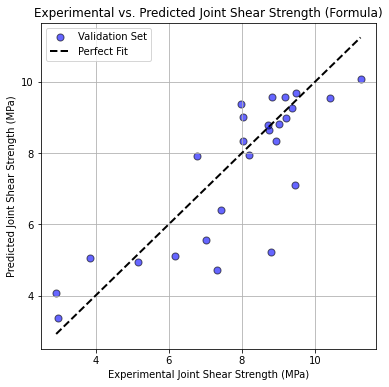

In [5]:
# Training and predict on validation set for CASE 1
svr_case1 = SVR(kernel='linear', C=best_reg_linear, epsilon= best_epsilon_linear)
svr_case1.fit(X_train_case1, y_train_case1)

C1, C2, C3 = svr_case1.coef_[0]
intercept = svr_case1.intercept_[0]

print(f"Final Equation: V_j = [{C1:.3f} * term_1_n_fc + {C2:.3f} * term_RI_fc + {C3:.3f} * term_fy_A0 + {intercept:.3f}]\n")


# Validation predictions
y_val_pred_case1 = ( C1 * X_val_case1['term_1_n_fc'] + C2 * X_val_case1['term_RI_fc'] + C3 * X_val_case1['term_fy_A0'])



# Output the metrics
mse_val_case1 = mean_squared_error(y_val_case1, y_val_pred_case1)
rmse_val_case1 = np.sqrt(mse_val_case1)
mae_val_case1 = mean_absolute_error(y_val_case1, y_val_pred_case1)
mape_val_case1 = mean_absolute_percentage_error(y_val_case1, y_val_pred_case1) *100
r_case1 = np.corrcoef(y_val_case1.to_numpy().flatten(), y_val_pred_case1.to_numpy().flatten())[0, 1]
r2_val_case1 = r2_score(y_val_case1, y_val_pred_case1)
print('Results of validation set following the equation')
print(f'Mean Squared Error: {mse_val_case1:.2f}')
print(f'Root Mean Squared Error: {rmse_val_case1:.2f}')
print(f'Mean Absolute Percent Error: {mape_val_case1:.2f}')
print("Correlation Coefficient (R):", r_case1)
print(f'R-squared (R²): {r2_val_case1:.2f}\n')

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_val_case1, y_val_pred_case1, alpha=0.6, color="blue", edgecolors='k', s=50, label="Validation Set")
plt.plot([y_val_case1.min(), y_val_case1.max()], [y_val_case1.min(), y_val_case1.max()], 'k--', lw=2, label="Perfect Fit")
plt.xlabel("Experimental Joint Shear Strength (MPa)")
plt.ylabel("Predicted Joint Shear Strength (MPa)")
plt.title("Experimental vs. Predicted Joint Shear Strength (Formula)")
plt.legend()
plt.grid(True)
plt.savefig(f'../svr_results/validation_plot_case1.png', dpi =1000)
plt.show()

## Case 2 - Using all input variables

The best combination is Regularization = 3, Epsilon = 0.5 with the lowest MSE of 0.7609414183170161


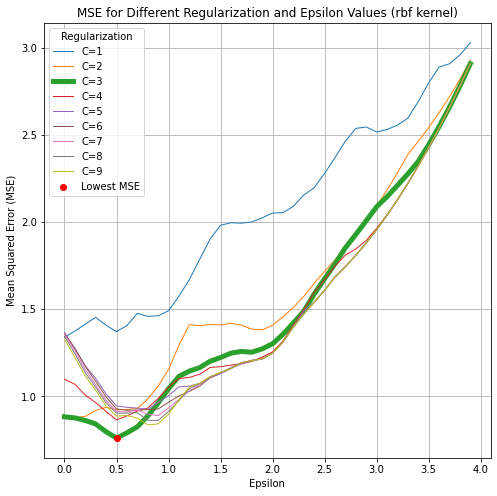

In [6]:

# Scale the data because rbf focus on distances
x_scaled = StandardScaler().fit_transform(X)
x_train_case2, x_temp, y_train_case2, y_temp = train_test_split(x_scaled,y, test_size = 0.4, shuffle=True, random_state = 42)
x_val_case2, x_test_case2, y_val_case2, y_test_case2 = train_test_split(x_temp,y_temp, test_size = 0.5, shuffle=True, random_state = 42)
# Find the best combination for CASE 2
best_reg_rbf, best_epsilon_rbf = nested_parameter_testing("rbf",x_train_case2,y_train_case2,x_val_case2,y_val_case2)

Results of validation set following the equation
Mean Squared Error: 0.76
Root Mean Squared Error: 0.87
Mean Absolute Percentage Error: 9.22
Correlation Coefficient (R): 0.9136182506070537
R-squared (R²): 0.82



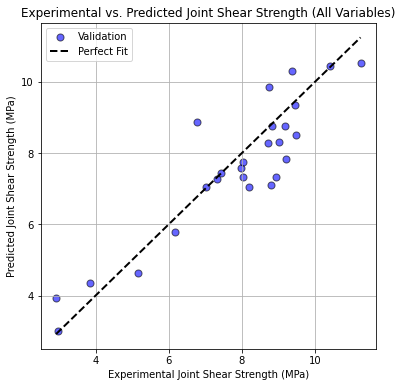

In [8]:
# Training and predict on validation set for CASE 2
svr_case2 = SVR(C=best_reg_rbf, epsilon=best_epsilon_rbf)
svr_case2.fit(x_train_case2, y_train_case2.values.ravel())
y_val_pred_case2 = svr_case2.predict(x_val_case2)

# Output the metrics
mse_val_case2 = mean_squared_error(y_val_case2, y_val_pred_case2)
rmse_val_case2 = np.sqrt(mse_val_case2)
mae_val_case2 = mean_absolute_error(y_val_case2, y_val_pred_case2)
mape_val_case2 = mean_absolute_percentage_error(y_val_case2, y_val_pred_case2) *100
r_case2 = np.corrcoef(y_val_case2.to_numpy().flatten(), y_val_pred_case2.flatten())[0, 1]
r2_val_case2 = r2_score(y_val_case2, y_val_pred_case2)
print('Results of validation set following the equation')
print(f'Mean Squared Error: {mse_val_case2:.2f}')
print(f'Root Mean Squared Error: {rmse_val_case2:.2f}')
print(f'Mean Absolute Percentage Error: {mape_val_case2:.2f}')
print("Correlation Coefficient (R):", r_case2)
print(f'R-squared (R²): {r2_val_case2:.2f}\n')

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_val_case2, y_val_pred_case2, alpha=0.6, color="blue", edgecolors='k', s=50, label="Validation")
plt.plot([y_val_case2.min(), y_val_case2.max()], [y_val_case2.min(), y_val_case2.max()], 'k--', lw=2, label="Perfect Fit")
plt.xlabel("Experimental Joint Shear Strength (MPa)")
plt.ylabel("Predicted Joint Shear Strength (MPa)")
plt.title("Experimental vs. Predicted Joint Shear Strength (All Variables)")
plt.legend()
plt.grid(True)
plt.savefig('../svr_results/validation_plot_case2.png', dpi =1000)
plt.show()
